<a href="https://colab.research.google.com/github/PN-pitchayut/PN-pitchayut/blob/main/Test_of_Brain_Tumor_Classification_EffNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
# Imports 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import random
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# base_path and labels.
base_path = '/content/drive/MyDrive/MRI Brain Tumors'
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [ ]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 32
VERBOSE = 1

Read the data set

In [ ]:
# Dataset from the training folder.
x_train=[]
y_train=[]
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'/content/drive/MyDrive/MRI Brain Tumors/Training'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Dataset from the testing folder..

for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'/content/drive/MyDrive/MRI Brain Tumors/Testing'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')

100%|██████████| 826/826 [00:26<00:00, 30.91it/s] 


Training dataset Loading complete.


100%|██████████| 100/100 [00:01<00:00, 57.46it/s]


Testing dataset Loading complete.


Encoding the y_train and y_test to numbers and one-hot encoding it.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


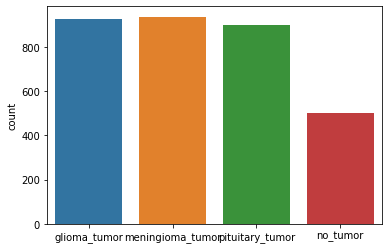

In [ ]:
sns.countplot(y_train)
plt.show()

Sample image in each class

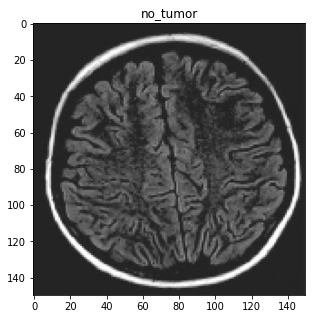

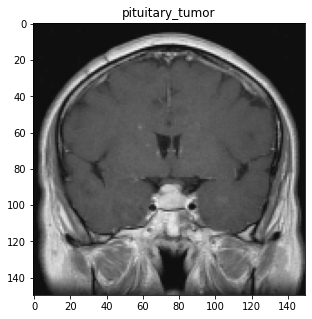

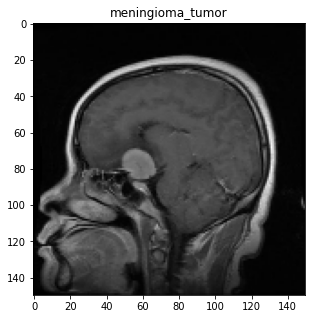

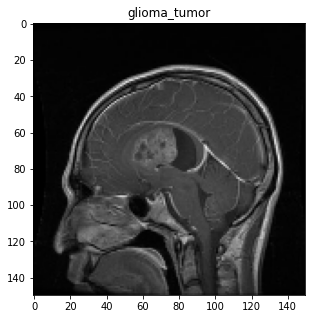

In [ ]:
j=0
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [ ]:
#Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True, vertical_flip=False
)

datagen.fit(x_train)
x_train.shape

(3264, 150, 150, 3)

In [ ]:
# Splitting of dataset for Testing.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.10, random_state=0)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (2937, 150, 150, 3)  Test : (327, 150, 150, 3)
Shapes Y : Train : (2937,)  Test : (327,)


Encoding the y_train and y_test to numbers and one-hot encoding it.

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

1.Tranfer learning_EfficientNetB0

In [ ]:
# Importing the model and initializing.
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Adding Top Layers.
model1 = effnet.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(0.5)(model1)
model1 = tf.keras.layers.Dense(4, activation = 'softmax')(model1)
model1 = tf.keras.models.Model(inputs = effnet.input, outputs = model1)

1.1Model Summary

In [ ]:
# Model summary.
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [ ]:
# Compiling Model
model1.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [ ]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

1.2 Training the model

In [ ]:
# Fitting the model
history1 = model1.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.8320
Epoch 1: val_accuracy improved from -inf to 0.80272, saving model to effnet.h5
83/83 [==============================] - 401s 5s/step - loss: 0.4653 - accuracy: 0.8320 - val_loss: 0.5470 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9398
Epoch 2: val_accuracy improved from 0.80272 to 0.91837, saving model to effnet.h5
83/83 [==============================] - 372s 4s/step - loss: 0.1701 - accuracy: 0.9398 - val_loss: 0.2785 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9542
Epoch 3: val_accuracy did not improve from 0.91837
83/83 [==============================] - 366s 4s/step - loss: 0.1430 - accuracy: 0.9542 - val_loss: 0.3001 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.1235 - 

1.3 Training, loss vs epoch

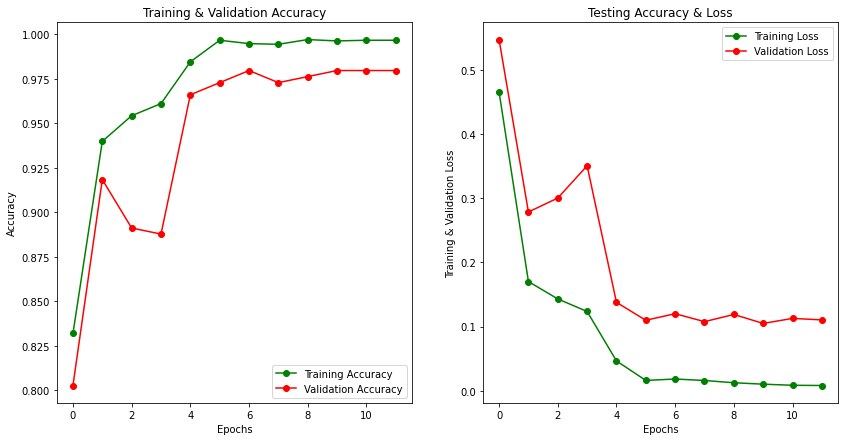

In [ ]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()


1.4 Model Performance

In [ ]:
# Evaluating Model.
result1=model1.evaluate(x_test, y_test)
print("Testing Loss :", result1[0])
print("Testing Accuracy :", result1[1]*100, "%")

11/11 [==============================] - 8s 727ms/step - loss: 0.1549 - accuracy: 0.9602
Testing Loss : 0.1549239456653595
Testing Accuracy : 96.02446556091309 %


In [ ]:
predictions1 = model1.predict(x_test)
predictions1 = np.argmax(predictions1, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

1.5 Evaluation Metrics

In [ ]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions1 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.98      0.97      0.98       103
           2       0.91      0.96      0.93        82
           3       0.98      0.94      0.96        88

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



1.6 Confusion Matrix

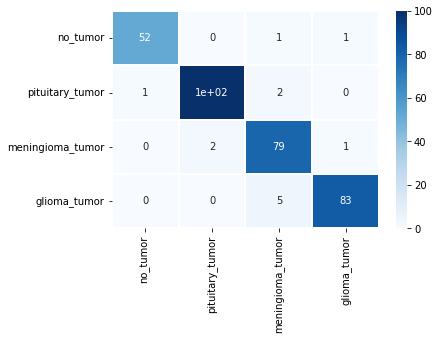

In [ ]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions1)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)